In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## locate sessions with pfc or mec

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
108,Z:\Data\FujisawaS\EE\EE0705fm
109,Z:\Data\FujisawaS\EE\EE0706fm
110,Z:\Data\FujisawaS\EE\EE0708fm
111,Z:\Data\HMC1\day12


## main analysis

In [ ]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1"
    )

batch_analysis.run(
    sessions,
    save_path,
    assembly_multi_region.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
prop_df, assembly_df = assembly_multi_region.load_results(save_path)

## remove rows with not enough data

In [182]:
prop_df = prop_df[~((prop_df.n_pfc == 0) & prop_df.labels.str.contains("PFC"))]
prop_df = prop_df[~((prop_df.n_mec == 0) & prop_df.labels.str.contains("MEC"))]
prop_df = prop_df[~((prop_df.n_sup == 0) & prop_df.labels.str.contains("Superficial"))]
prop_df = prop_df[~((prop_df.n_deep == 0) & prop_df.labels.str.contains("Deep"))]
prop_df = prop_df[~(prop_df.n_assemblies == 0)]


prop_df = prop_df[~((prop_df.n_pfc < 2) & prop_df.labels.str.contains("PFC"))]
prop_df = prop_df[~((prop_df.n_mec < 2) & prop_df.labels.str.contains("MEC"))]
prop_df = prop_df[~((prop_df.n_sup < 2) & prop_df.labels.str.contains("Superficial"))]
prop_df = prop_df[~((prop_df.n_deep < 2) & prop_df.labels.str.contains("Deep"))]

prop_df = prop_df[(prop_df.n_sup > 2)]
prop_df = prop_df[(prop_df.n_deep > 2)]

prop_df["counts_cross_region"] = prop_df.prop_cross_region * prop_df.n_assemblies
# prop_df.describe()
prop_df['constant'] = 1
prop_df

,prop_cross_region,labels,n_deep,n_sup,n_mec,n_pfc,n_assemblies,basepath,counts_cross_region,constant
21,0.176471,Superficial MEC,62,11,50,0,17,Z:\Data\AYAold\AYA7\day24,3.0,1
23,0.529412,Deep MEC,62,11,50,0,17,Z:\Data\AYAold\AYA7\day24,9.0,1
29,0.250000,Superficial MEC,83,27,79,0,8,Z:\Data\AYAold\AYA9\day12,2.0,1
31,0.500000,Deep MEC,83,27,79,0,8,Z:\Data\AYAold\AYA9\day12,4.0,1
33,1.000000,Superficial MEC,16,19,51,0,2,Z:\Data\AYAold\AYA9\day14,2.0,1
...,...,...,...,...,...,...,...,...,...,...
251,0.200000,Deep MEC,8,51,7,0,15,Z:\Data\Kenji\ec016.577_590,3.0,1
288,0.222222,Superficial PFC,19,14,0,13,9,Z:\Data\ORproject\OR18\day1,2.0,1
290,0.111111,Deep PFC,19,14,0,13,9,Z:\Data\ORproject\OR18\day1,1.0,1
292,0.000000,Superficial PFC,14,3,0,15,7,Z:\Data\ORproject\OR18\day2,0.0,1


In [166]:
prop_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_prop_df.csv")

In [183]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
temp_df = prop_df[(prop_df.labels == "Deep MEC") | (prop_df.labels == "Superficial MEC")] 
glm = smf.glm(
    "prop_cross_region ~ labels",
    data=temp_df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(temp_df["n_assemblies"]),
)
res_f = glm.fit()
print(res_f.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      prop_cross_region   No. Observations:                   82
Model:                            GLM   Df Residuals:                      776
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.65
Date:                Thu, 14 Jul 2022   Deviance:                       158.62
Time:                        18:27:51   Pearson chi2:                     168.
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001228
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [187]:
temp_df = prop_df[(prop_df.labels == "Deep PFC") | (prop_df.labels == "Superficial PFC")] 
glm = smf.glm(
    "prop_cross_region ~ labels",
    data=temp_df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(temp_df["n_assemblies"]),
)
res_f = glm.fit()
print(res_f.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      prop_cross_region   No. Observations:                   22
Model:                            GLM   Df Residuals:                      286
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88.689
Date:                Thu, 14 Jul 2022   Deviance:                       30.027
Time:                        18:28:12   Pearson chi2:                     25.4
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01113
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [185]:
for l in prop_df.labels.unique():
    print(
        l,
        (prop_df[prop_df.labels.str.contains(l)].counts_cross_region.sum())
        / prop_df[prop_df.labels.str.contains(l)].n_assemblies.sum(),
    )


Superficial MEC 0.12853470437017994
Deep MEC 0.13624678663239073
Superficial PFC 0.1388888888888889
Deep PFC 0.1597222222222222


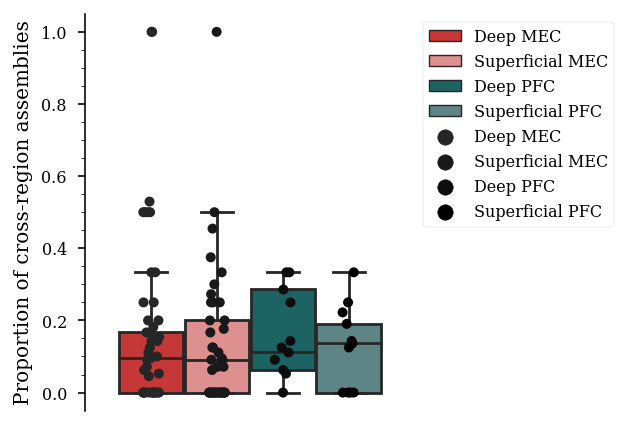

In [186]:
def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return df


def weighted_boxplot(df, weight_col):
    sns.boxplot(
        x="constant",
        y="prop_cross_region",
        hue="labels",
        hue_order=group_colors.keys(),
        showfliers=False,
        data=reindex_df(df, weight_col=weight_col),
    )

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)), edgecolor=None
)
group_colors = {
    "Deep MEC": "#de2020",
    "Superficial MEC": "#eb8383",
    "Deep PFC": "#116f70",
    "Superficial PFC": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()

weighted_boxplot(prop_df, "n_assemblies")

sns.stripplot(
    x="constant",
    y="prop_cross_region",
    hue="labels",
    dodge=True,
    color="k",
    hue_order=group_colors.keys(),
    data=prop_df,
    ax=ax,
)
plt.ylabel("Proportion of cross-region assemblies")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.grid()
sns.despine(bottom=True)
# turn off x axis
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.yaxis.set_minor_locator(AutoMinorLocator())

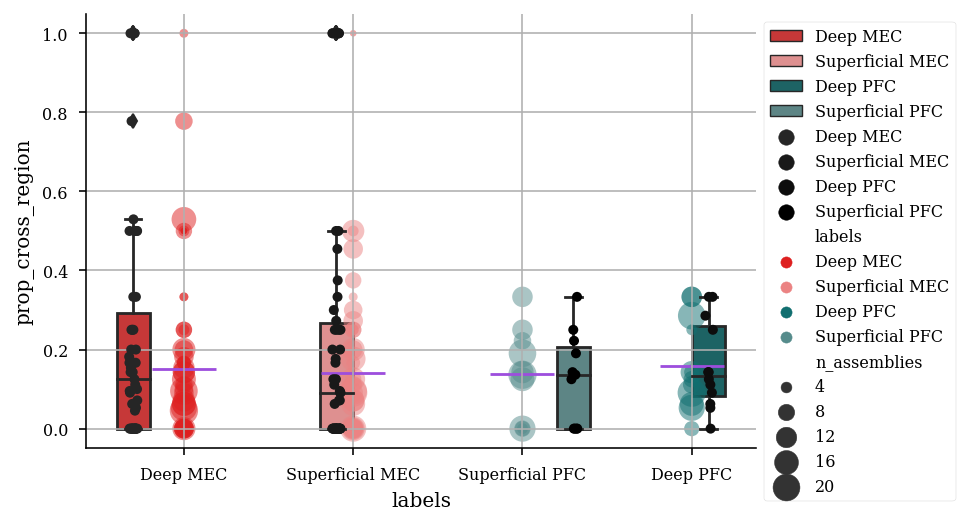

In [144]:
def weighted_average_m1(distribution, weights):
    return sum([distribution[i] * weights[i] for i in range(len(distribution))]) / sum(
        weights
    )

group_colors = {
    "Deep MEC": "#de2020",
    "Superficial MEC": "#eb8383",
    "Deep PFC": "#116f70",
    "Superficial PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
plt.figure()
ax = plt.gca()
sns.boxplot(x="labels", y="prop_cross_region",hue="labels", dodge=True, hue_order=group_colors.keys(),data=prop_df,ax=ax)
sns.stripplot(x="labels", y="prop_cross_region",hue="labels", dodge=True,color='k',hue_order=group_colors.keys(),data=prop_df,ax=ax)

g = sns.scatterplot(
    x="labels",
    y="prop_cross_region",
    hue="labels",
    hue_order=group_colors.keys(),
    data=prop_df,
    size="n_assemblies",
    linewidth=0,
    sizes=(1, 200),
    alpha=0.5,
    ax=ax
)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Superficial MEC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Superficial MEC")].n_assemblies.values,
)
plt.scatter("Superficial MEC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Deep MEC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Deep MEC")].n_assemblies.values,
)
plt.scatter("Deep MEC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Superficial PFC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Superficial PFC")].n_assemblies.values,
)
plt.scatter("Superficial PFC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Deep PFC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Deep PFC")].n_assemblies.values,
)
plt.scatter("Deep PFC",mean,marker="_",color='#9d4edd',s=1000)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
sns.despine()

In [ ]:
def weighted_average_m1(distribution, weights):
    return sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights)

def plot_prop_custom(df_prop,y_name,w_name,ax):
    x = (df_prop.group == 'pae') * 1 + (np.random.randint(-100,100,len(df_prop))*.001)

    y = df_prop[y_name]
    h = ax.scatter(
        x,y,
        color='k',
        alpha=.25,
        s=df_prop[w_name]
    )
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='control')][y_name]),
        np.array(df_prop[(df_prop.group=='control')][w_name])
    )
    ax.scatter(0,mean,marker="_",color='#9d4edd',s=200)
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='pae')][y_name]),
        np.array(df_prop[(df_prop.group=='pae')][w_name])
    )
    ax.scatter(1,mean,marker="_",color='#9d4edd',s=200)
    
    ax.set_xlim(-.5,1.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(['control','pae'])
    return h

## testing below

In [7]:
import pickle
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl"

with open(session, "rb") as f:
    results = pickle.load(f)

## locate deep_pfc, deep_mec, sup_pfc, sup_mec assemblies

In [24]:
# results.get("react").cell_metrics.deep
for ims in is_member_sig:
    print(results.get("react").cell_metrics.brainRegion.values[ims])

['PFC' 'PFC' 'PFC']
['PFC' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1so' 'CA1sp' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sp' 'CA1so' 'CA1sr']
['PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1sp' 'CA1so']
['MEC' 'MEC' 'MEC']
['CA1sp' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sr' 'CA1sp' 'CA1so' 'CA1sr']
['PFC' 'PFC' 'PFC' 'CA1so']
['PFC' 'PFC' 'CA1so' 'CA1sp' 'CA1sp' 'MEC' 'MEC' 'MEC' 'MEC']
['PFC' 'PFC']
['CA1sp' 'CA1so' 'CA1sp' 'CA1sr' 'CA1so' 'CA1so' 'CA1so' 'CA1so']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1so' 'CA1so']
['CA1sp' 'CA1sp' 'CA1sr']
['PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1so' 'CA1so' 'CA1sr']
['PFC' 'PFC' 'PFC' 'PFC']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sr' 'CA1sp' 'CA1sp' 'CA1sr' 'CA1sp']
['CA1so' 'CA1so' 'CA1sr' 'CA1so' 'CA1sp' 'MEC']
['PFC' 'PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1sp']


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


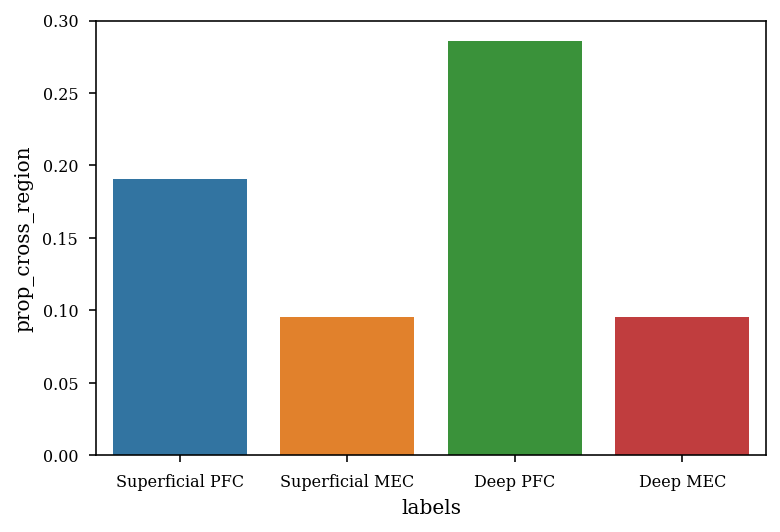

In [42]:
def compile_results_df(results):

    patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(results.get("react").patterns)


    assembly_df = pd.DataFrame()
    assembly_df["patterns"] = patterns.ravel()
    assembly_df["is_member_sig"] = is_member_sig.ravel()
    assembly_df["assembly_n"] = (np.ones_like(patterns).T * np.arange(patterns.shape[0])).T.astype(int).ravel()
    assembly_df["UID"] = np.tile(results.get("react").cell_metrics.UID.values, patterns.shape[0])
    assembly_df["putativeCellType"] = np.tile(results.get("react").cell_metrics.putativeCellType.values, patterns.shape[0])
    assembly_df["brainRegion"] = np.tile(results.get("react").cell_metrics.brainRegion.values, patterns.shape[0])
    assembly_df["deepSuperficial"] = np.tile(results.get("react").cell_metrics.deepSuperficial.values, patterns.shape[0])
    assembly_df["deepSuperficialDistance"] = np.tile(results.get("react").cell_metrics.deepSuperficialDistance.values, patterns.shape[0])
    assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(assembly_df)

    deep_mec = []
    deep_pfc = []
    superficial_mec = []
    superficial_pfc = []

    for n in assembly_df.assembly_n.unique():
        temp_assembly_df = assembly_df[
            (assembly_df.assembly_n == n) & (assembly_df.is_member_sig)
        ]
        deep_mec.append(
            any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
            & any((temp_assembly_df.deepSuperficial == "Deep"))
        )
        deep_pfc.append(
            any(temp_assembly_df.brainRegion.str.contains("PFC"))
            & any((temp_assembly_df.deepSuperficial == "Deep"))
        )
        superficial_mec.append(
            any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
            & any((temp_assembly_df.deepSuperficial == "Superficial"))
        )
        superficial_pfc.append(
            any(temp_assembly_df.brainRegion.str.contains("PFC"))
            & any((temp_assembly_df.deepSuperficial == "Superficial"))
        )

    prop_df = pd.DataFrame()
    prop_df["prop_cross_region"] = [
        np.mean(np.array(superficial_pfc) > 0),
        np.mean(np.array(superficial_mec) > 0),
        np.mean(np.array(deep_pfc) > 0),
        np.mean(np.array(deep_mec) > 0),
    ]
    prop_df["labels"] = ["Superficial PFC", "Superficial MEC", "Deep PFC", "Deep MEC"]

    results.get("react").cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(results.get("react").cell_metrics)

    prop_df["n_deep"] = sum(results.get("react").cell_metrics.deepSuperficial == "Deep")
    prop_df["n_sup"] = sum(results.get("react").cell_metrics.deepSuperficial == "Superficial")
    prop_df["n_mec"] = sum(results.get("react").cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
    prop_df["n_pfc"] = sum(results.get("react").cell_metrics.brainRegion.str.contains("PFC"))
    prop_df["n_assemblies"] = len(assembly_df.assembly_n.unique())
    prop_df["basepath"] = results.get("react").basepath

    return prop_df, assembly_df


prop_df, assembly_df = compile_results_df(results)
ax = sns.barplot(x="labels", y="prop_cross_region", data=prop_df)

In [41]:
results.get("react").basepath

'Z:\\Data\\HMC1\\day10'

In [49]:
def get_pre_post_assembly_strengths(basepath,verbose=False):
    """
    Gets the pre and post assembly strengths
    """
    # initialize session
    m1 = assembly_reactivation.AssemblyReact(
        basepath,
        brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
        putativeCellType="Pyr",
        weight_dt=0.02,
    )

    # load data
    m1.load_data()
    # check if no cells were found
    if m1.cell_metrics.shape[0] == 0:
        return None
    # restrict to pre/task/post epochs
    m1.restrict_epochs_to_pre_task_post()
    # get weights for task outside ripples
    # % (TODO: use more robust method to locate epochs than index)
    if verbose:
        print("Getting weights...")
    m1.get_weights(m1.epochs[1][~m1.ripples])

    # get assembly activity
    if verbose:
        print("Getting assembly activity...")
    assembly_act_pre = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[0]])
    assembly_act_task = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[1]])
    assembly_act_post = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[2]])
    results = {
        "assembly_act_pre": assembly_act_pre,
        "assembly_act_task": assembly_act_task,
        "assembly_act_post": assembly_act_post,
        "react": m1,
    }

    return results


basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"
results = get_pre_post_assembly_strengths(basepath,verbose=True)

Getting weights...
Getting assembly activity...


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than

(102,)

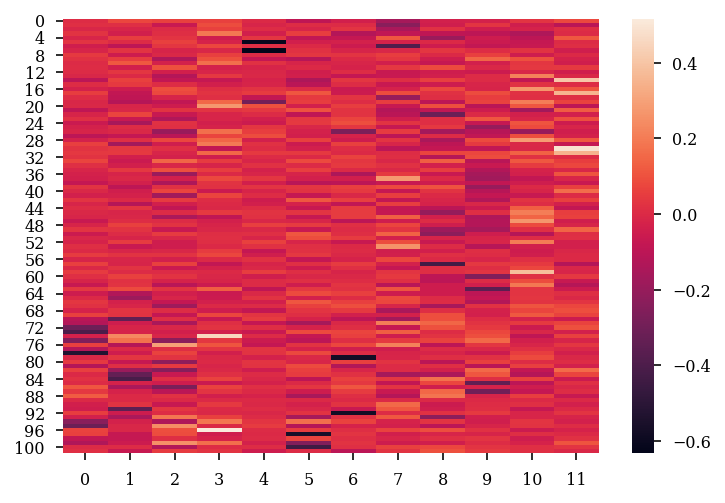

In [64]:
results["react"].patterns.shape
dir(results["react"])

results["react"].cell_metrics.shape

sns.heatmap(results["react"].patterns.T)

results["react"].cell_metrics.brainRegion.shape

In [65]:
ar = results["react"]

In [5]:
basepath = r"Z:\Data\HMC1\day13"

ar = assembly_reactivation.AssemblyReact(basepath, brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
        putativeCellType="Pyr")
ar.load_data()
ar.restrict_epochs_to_pre_task_post()

# ar.get_weights([ar.ripples.expand(0.2)])
ar.get_weights([ar.epochs[1]])


In [ ]:
# ar = assembly_reactivation.AssemblyReact(basepath, brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
#         putativeCellType="Pyr")
# ar.load_data()
# ar.ripples = ar.ripples.expand(0.2)
basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"

results = assembly_reactivation.get_pre_post_assembly_strengths(basepath)

In [66]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(ar.patterns)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [79]:
is_member

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [67]:
patterns.shape, is_member_sig.shape, np.array(keep_assembly).shape, is_member.shape

((6, 102), (6, 102), (12,), (12, 102))

In [68]:
assembly_df = pd.DataFrame()
assembly_df["patterns"] = patterns.ravel()
assembly_df["is_member_sig"] = is_member_sig.ravel()
assembly_df["assembly_n"] = (np.ones_like(patterns).T * np.arange(patterns.shape[0])).T.astype(int).ravel()
assembly_df["UID"] = np.tile(ar.cell_metrics.UID.values, patterns.shape[0])
assembly_df["putativeCellType"] = np.tile(ar.cell_metrics.putativeCellType.values, patterns.shape[0])
assembly_df["brainRegion"] = np.tile(ar.cell_metrics.brainRegion.values, patterns.shape[0])
assembly_df["deepSuperficial"] = np.tile(ar.cell_metrics.deepSuperficial.values, patterns.shape[0])
assembly_df["deepSuperficialDistance"] = np.tile(ar.cell_metrics.deepSuperficialDistance.values, patterns.shape[0])
assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(assembly_df)

assembly_df

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
0,0.006238,False,0,41,Pyramidal Cell,PFC,Cortical,NaN
1,0.017089,False,0,49,Pyramidal Cell,PFC,Cortical,NaN
2,-0.011791,False,0,50,Pyramidal Cell,PFC,Cortical,NaN
3,0.027435,False,0,62,Pyramidal Cell,PFC,Cortical,NaN
4,-0.014103,False,0,63,Pyramidal Cell,PFC,Cortical,NaN
...,...,...,...,...,...,...,...,...
607,-0.003268,False,5,358,Pyramidal Cell,CA1,Deep,-176.695637
608,0.022124,False,5,359,Pyramidal Cell,CA1,Deep,-156.695637
609,0.103919,False,5,361,Pyramidal Cell,CA1,Deep,-96.695637
610,0.028437,False,5,362,Pyramidal Cell,CA1,Deep,-136.695637


In [69]:
# target_regions = 

for n in assembly_df.assembly_n.unique():
    for ca1_sub in ["Deep", "Superficial"]:
        for region in ["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]:
            
            source_idx = any(
                (assembly_df.assembly_n == n)
                & (assembly_df.is_member_sig)
                & (assembly_df.deepSuperficial == ca1_sub)
            )
            targ_idx = any(
                (assembly_df.assembly_n == n)
                & (assembly_df.is_member_sig)
                & assembly_df.brainRegion.str.contains(region)
            )
            if source_idx & targ_idx:
                assembly_df.loc[assembly_df.assembly_n == n, "cross_region"] = (
                    ca1_sub + "_" + region
                )
            else:
                assembly_df.loc[assembly_df.assembly_n == n, "cross_region"] = "None"


In [70]:
sum(assembly_df.cross_region == "Superficial_EC1|EC2|EC3|EC4|EC5|MEC") / assembly_df.shape[0]
assembly_df.cross_region.value_counts()

None    612
Name: cross_region, dtype: int64

In [22]:
assembly_df[assembly_df.brainRegion.str.contains(region) | (assembly_df.deepSuperficial == "Deep")]

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
135,0.022262,False,0,272,Pyramidal Cell,CA1so,Deep,-150.0000
136,0.005076,False,0,274,Pyramidal Cell,CA1so,Deep,-30.0000
138,0.012666,False,0,279,Pyramidal Cell,CA1so,Deep,-130.7624
139,0.040901,False,0,281,Pyramidal Cell,CA1so,Deep,-105.0000
140,-0.016030,False,0,283,Pyramidal Cell,CA1so,Deep,-70.7624
...,...,...,...,...,...,...,...,...
6694,-0.028502,False,20,540,Pyramidal Cell,MEC,Cortical,NaN
6695,-0.005852,False,20,541,Pyramidal Cell,MEC,Cortical,NaN
6696,0.008489,False,20,542,Pyramidal Cell,MEC,Cortical,NaN
6697,0.006120,False,20,546,Pyramidal Cell,MEC,Cortical,NaN


In [71]:
deep_mec = []
deep_pfc = []
superficial_mec = []
superficial_pfc = []

for n in assembly_df.assembly_n.unique():
    temp_assembly_df = assembly_df[
        (assembly_df.assembly_n == n) & (assembly_df.is_member_sig)
    ]
    deep_mec.append(
        any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
        & any((temp_assembly_df.deepSuperficial == "Deep"))
    )
    deep_pfc.append(
        any(temp_assembly_df.brainRegion.str.contains("PFC"))
        & any((temp_assembly_df.deepSuperficial == "Deep"))
    )
    superficial_mec.append(
        any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
        & any((temp_assembly_df.deepSuperficial == "Superficial"))
    )
    superficial_pfc.append(
        any(temp_assembly_df.brainRegion.str.contains("PFC"))
        & any((temp_assembly_df.deepSuperficial == "Superficial"))
    )


In [11]:
any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")) & any((temp_assembly_df.deepSuperficial == "Deep"))

False

In [72]:
temp_assembly_df

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,cross_region
524,0.405214,True,5,102,Pyramidal Cell,PFC,Cortical,NaN,None
527,0.351466,True,5,105,Pyramidal Cell,PFC,Cortical,NaN,None
540,0.487538,True,5,143,Pyramidal Cell,PFC,Cortical,NaN,None
541,0.350603,True,5,144,Pyramidal Cell,PFC,Cortical,NaN,None


In [41]:
assembly_df[(assembly_df.assembly_n == 9) & (assembly_df.is_member_sig)]

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,cross_region
2913,0.154188,True,9,61,Pyramidal Cell,PFC,Cortical,NaN,None
2982,0.152820,True,9,176,Pyramidal Cell,PFC,Cortical,NaN,None
3023,0.224849,True,9,297,Pyramidal Cell,CA1sr,Superficial,49.23760,None
3056,0.139360,True,9,343,Pyramidal Cell,CA1sp,Superficial,73.05757,None
3111,0.179650,True,9,411,Pyramidal Cell,CA1so,Deep,-100.76240,None
3116,0.172396,True,9,419,Pyramidal Cell,CA1sp,middle,-10.76240,None
3118,0.230774,True,9,421,Pyramidal Cell,CA1so,Deep,-115.76240,None
3122,0.368816,True,9,425,Pyramidal Cell,CA1sp,middle,0.00000,None
3124,0.545400,True,9,429,Pyramidal Cell,CA1so,Deep,-40.76240,None


Text(0.5, 1.0, 'Number of cells in each assembly')

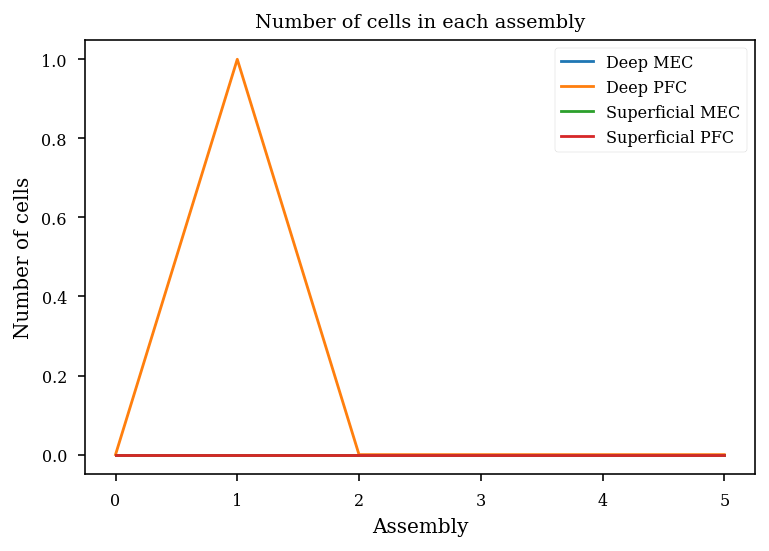

In [73]:
plt.plot(deep_mec)
plt.plot(deep_pfc)
plt.plot(superficial_mec)
plt.plot(superficial_pfc)
plt.legend(["Deep MEC", "Deep PFC", "Superficial MEC", "Superficial PFC"])
plt.xlabel("Assembly")
plt.ylabel("Number of cells")
plt.title("Number of cells in each assembly")


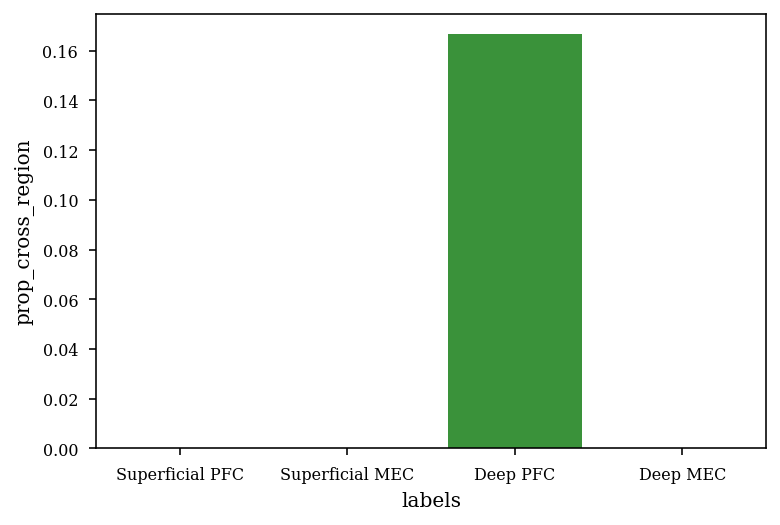

In [74]:
temp_df = pd.DataFrame()

temp_df["prop_cross_region"] = [
    np.mean(np.array(superficial_pfc) > 0),
    np.mean(np.array(superficial_mec) > 0),
    np.mean(np.array(deep_pfc) > 0),
    np.mean(np.array(deep_mec) > 0),
]
temp_df["labels"] = ["Superficial PFC", "Superficial MEC", "Deep PFC", "Deep MEC"]

ax = sns.barplot(x="labels", y="prop_cross_region", data=temp_df)

In [75]:
temp_df

,prop_cross_region,labels
0,0.000000,Superficial PFC
1,0.000000,Superficial MEC
2,0.166667,Deep PFC
3,0.000000,Deep MEC


In [15]:
def lighten_color(color, amount=0.5):
    """
    Lightens a color by a certain percentage.
    This is useful for adjusting colors for a particular element of a page.
    :param color: The hex color code, e.g. #AABBCC
    :param amount: The amount to lighten the color by.
    :return: The lightened color code in hex, e.g. #FFFFFF
    """
    try:
        c = color.lstrip('#')
        c = tuple(int(c[i:i + 2], 16) for i in (0, 2, 4))
        c = (
            int((1 - amount) * c[0] + amount * 255),
            int((1 - amount) * c[1] + amount * 255),
            int((1 - amount) * c[2] + amount * 255),
        )
        return '#%02x%02x%02x' % c
    except ValueError:
        return color

In [76]:
group_colors = {
    "CA1": "#615766",
    "MEC": "#de2020",
    "PFC": "#116f70",
}

colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
for reg in group_colors.keys():
    idx = ar.cell_metrics.brainRegion.str.contains(reg).values
    colors[:,idx] = [group_colors[reg]] * sum(idx)

for i in range(is_member_sig.shape[0]): 
    for j in range(is_member_sig.shape[1]):
        if is_member_sig[i,j] != 1:
            colors[i,j] = lighten_color(colors[i,j],0.5)


[Text(-0.5, 0, '-0.5'), Text(0.5, 0, '0.5')]

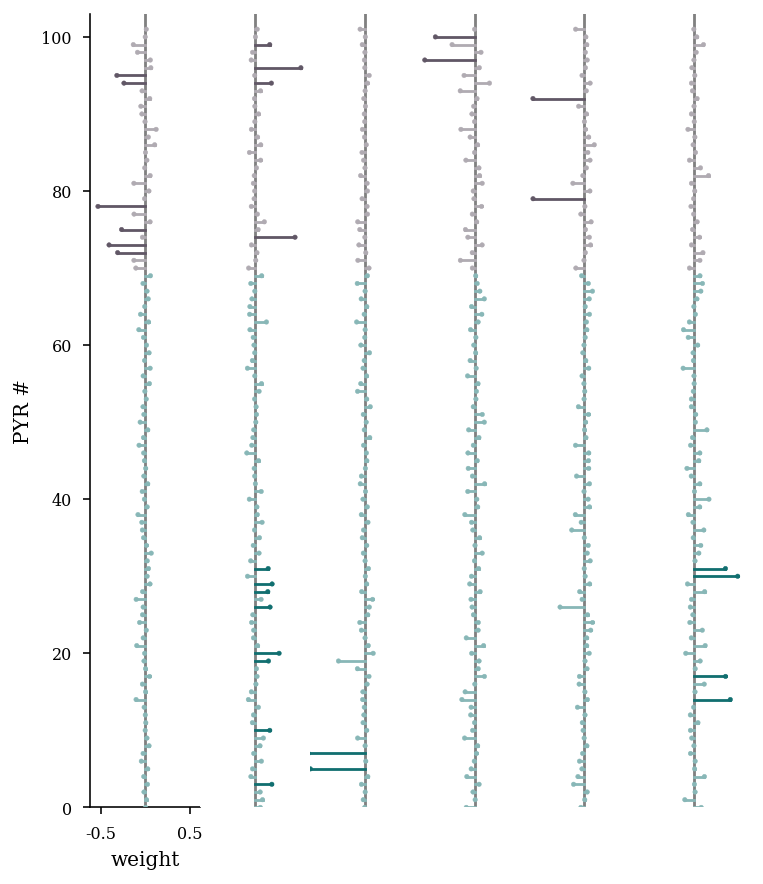

In [77]:
# patterns.shape
# colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
# lighten_color("#615766",.9)
# colors[is_member_sig] = "#615766"

fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=1, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=5)

    # axs[i].scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

for i in range(patterns.shape[0]):
    axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].set_ylim(0,patterns.shape[1]+1)

for i in range(patterns.shape[0]):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)  

for i in np.arange(1,patterns.shape[0]):
    axs[i].spines["left"].set_visible(False)  
    axs[i].spines["bottom"].set_visible(False)      
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])

axs[0].set_ylabel('PYR #')
axs[0].set_xlabel('weight')
axs[0].set_xticks([-.5,.5])
axs[0].set_xticklabels([-.5,.5])
    

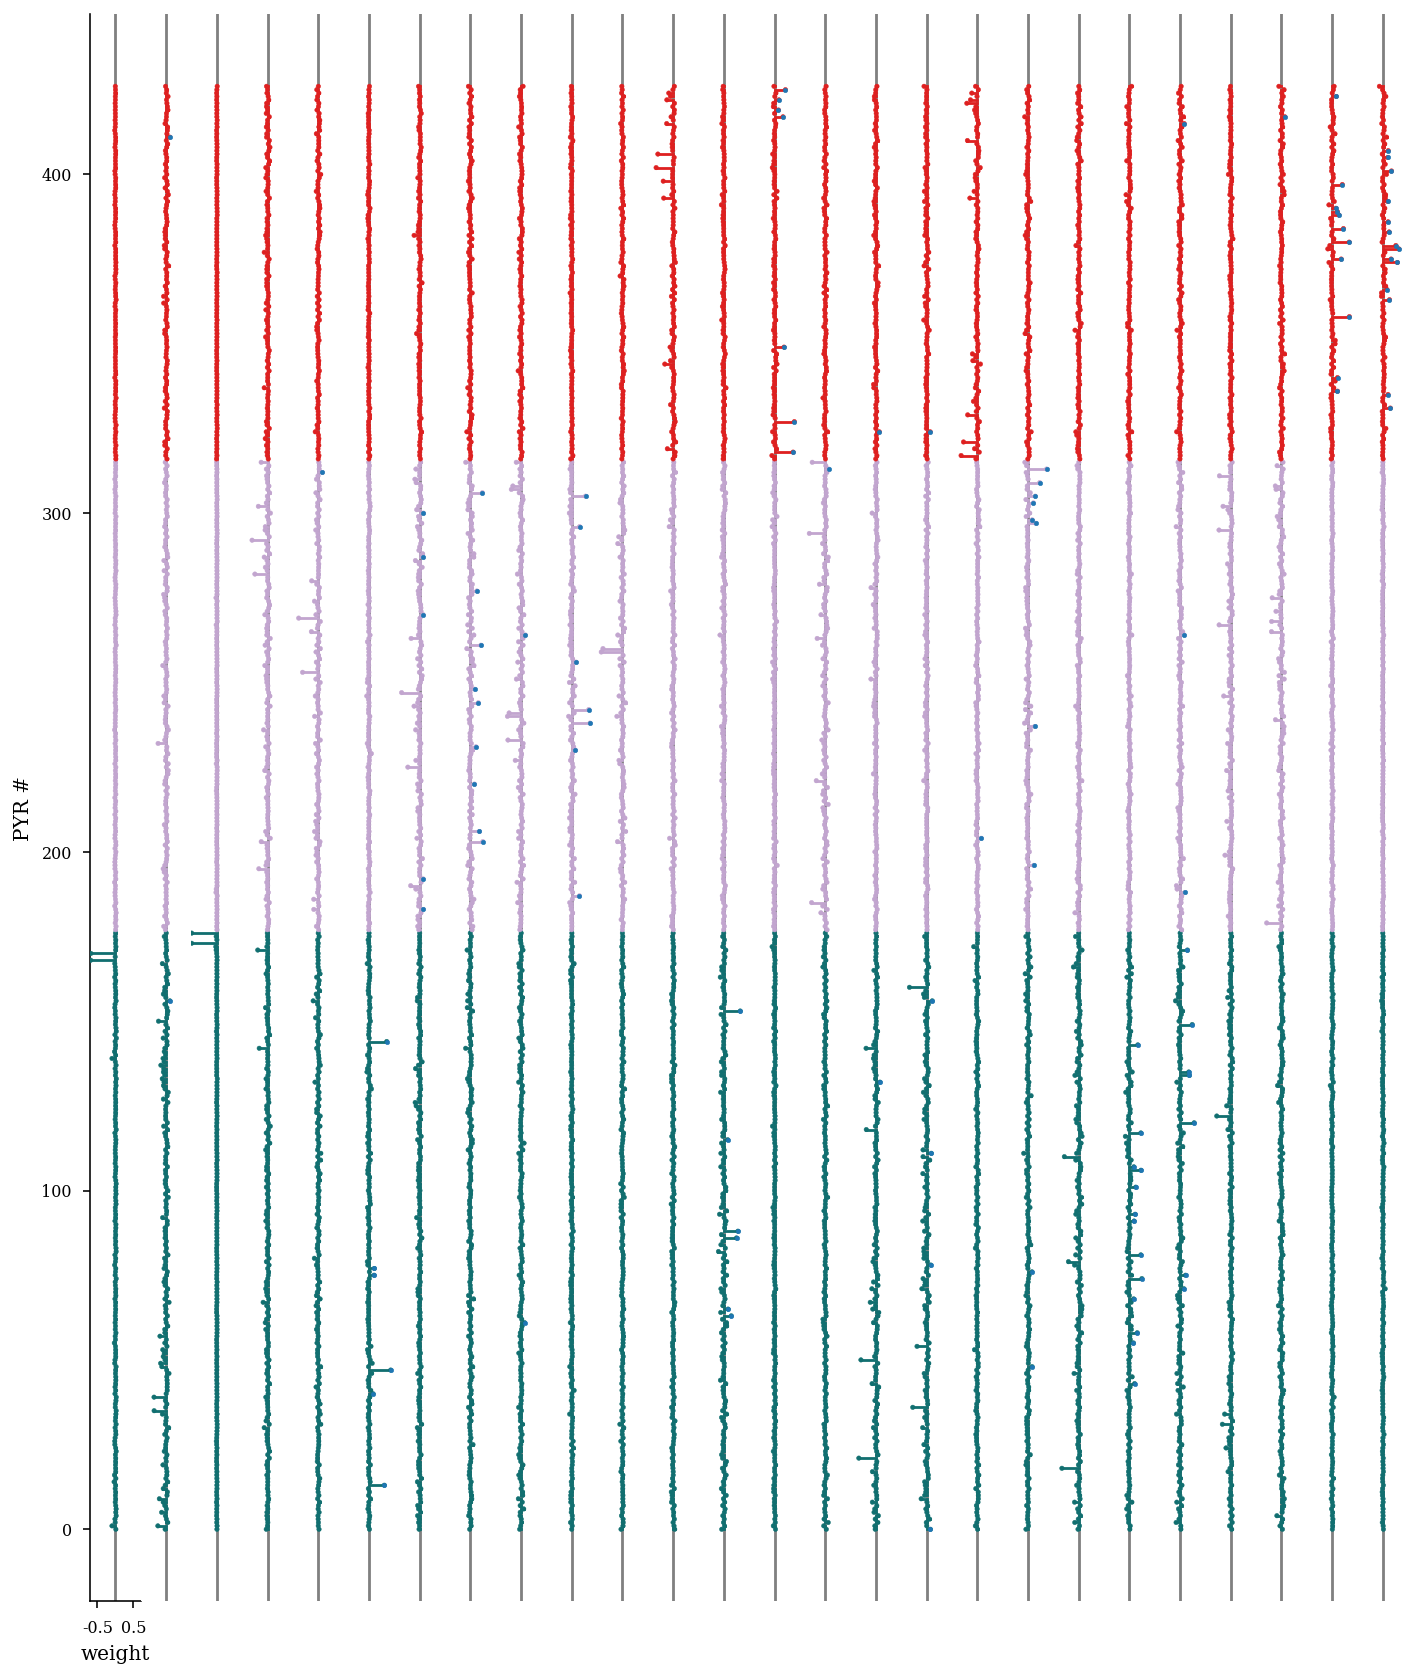

In [31]:
fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=2, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors,zorder=1000,s=5)

    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(assmbl[idx],np.arange(len(assmbl))[idx],zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[j],zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item,0]),[j,j],color=colors_sig[j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)  

    for i in np.arange(1,patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)  
        axs[i].spines["bottom"].set_visible(False)      
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel('PYR #')
    axs[0].set_xlabel('weight')
    axs[0].set_xticks([-.5,.5])
    axs[0].set_xticklabels([-.5,.5])


<StemContainer object of 3 artists>

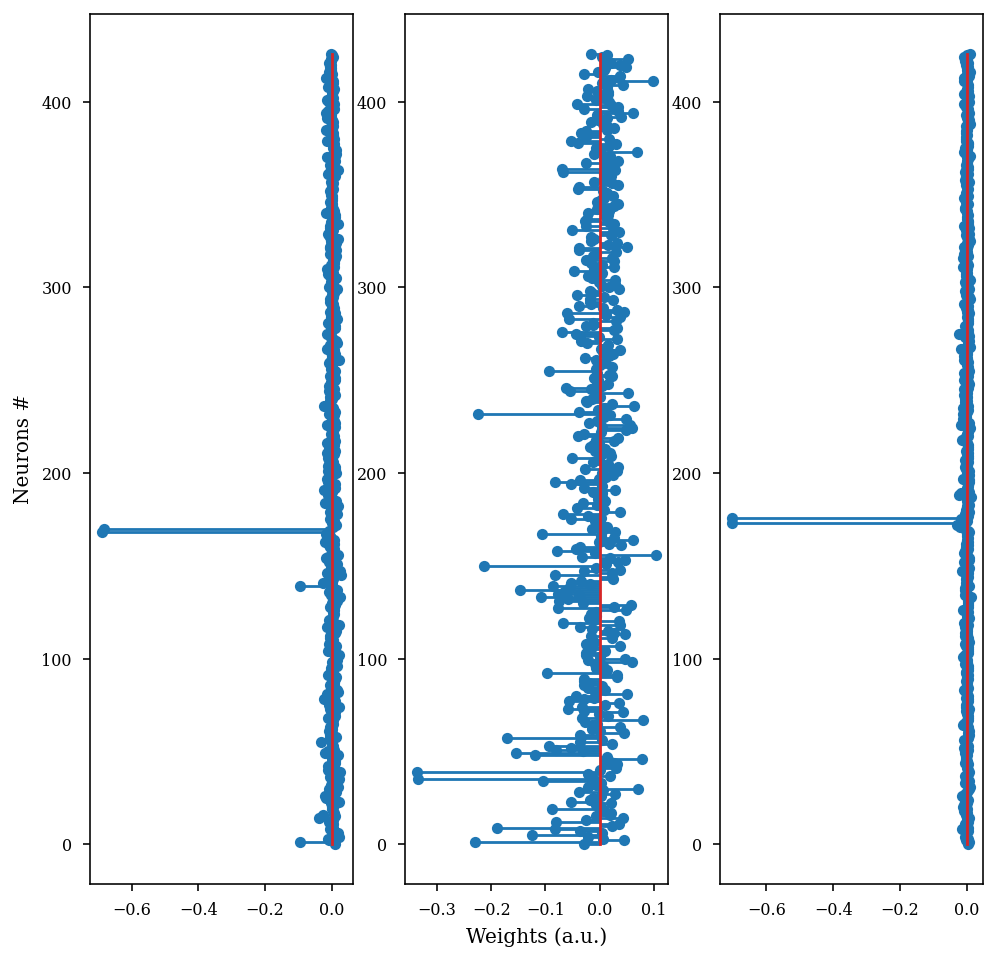

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
ax1 = plt.subplot(131)
plt.stem(patterns[0,:], orientation = 'horizontal')
ax1.set_ylabel('Neurons #')

ax2 = plt.subplot(132, sharey=ax1)
plt.stem(patterns[1,:], orientation = 'horizontal')
ax2.set_xlabel('Weights (a.u.)')

ax3 = plt.subplot(133, sharey=ax1)
plt.stem(patterns[2,:], orientation = 'horizontal')